In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [79]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [44]:
df = pd.read_csv('../Data/ABIDE_df.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
data_dir = '../Data/fc_data/'

In [12]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npz')]
files.sort()

In [55]:
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npz')) for sub in df['bids_folder'].values])

In [57]:
df = df.iloc[has_file]

In [74]:
n_subs = 200
data = np.zeros((n_subs,61, 73, 61, 51))
#for s in tqdm(range(len(df))):
for s in tqdm(range(n_subs)):
    sub = df['bids_folder'].values[s]
    datum = np.load(os.path.join(data_dir,sub + '.npz'))['data']
    data[s,:,:,:,:] = datum

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


In [77]:
data.shape

(200, 61, 73, 61, 51)

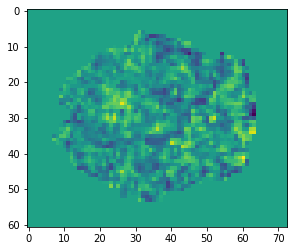

In [82]:
plt.imshow(data[10,:,:,20,1])

In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd
from glob import glob

In [88]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
      args (tensor): mean and log of variance of Q(z|X)
    # Returns:
      z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [90]:
Conv

tensorflow.python.keras.layers.convolutional.Conv3D

In [123]:
#def get_MRI_VAE_3D(input_shape=(64,64,64,1), latent_dim=2, batch_size = 32, disentangle=False, gamma=1):
#TODO: add discriminator loss, see if there is improvement. Perhaps try on shapes dataset if it's easier...
k = 48
input_shape=(k, k, k,51);latent_dim=2;batch_size = 10;disentangle=False;gamma=1



image_size, _, _, channels = input_shape
kernel_size = 3
filters = 16
intermediate_dim = 128
epochs = 10
nlayers = 2

  # VAE model = encoder + decoder
  # build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(nlayers):
    filters *= 2
    x = Conv3D(filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            strides=2,
            padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3],shape[4]))(x)

for i in range(nlayers):
    x = Conv3DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      activation='relu',
                      strides=2,
                      padding='same')(x)
    filters //= 2

outputs = Conv3DTranspose(filters=51,
                        kernel_size=kernel_size,
                        activation='sigmoid',
                        padding='same',
                        name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

#     decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

if disentangle:
    discriminator = Dense(1, activation='sigmoid')

    z1 = Lambda(lambda x: x[:int(batch_size/2),:int(latent_dim/2)])(z)
    z2 = Lambda(lambda x: x[int(batch_size/2):,:int(latent_dim/2)])(z)
    s1 = Lambda(lambda x: x[:int(batch_size/2),int(latent_dim/2):])(z)
    s2 = Lambda(lambda x: x[int(batch_size/2):,int(latent_dim/2):])(z)

    q_bar = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z2], axis=1),
      tf.keras.layers.concatenate([s2, z1], axis=1)],
      axis=0)
    q = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z1], axis=1),
      tf.keras.layers.concatenate([s2, z2], axis=1)],
      axis=0)

#         q_bar_score = discriminator(q_bar)
#         q_score = discriminator(q)        
#         tc_loss = K.log(q_score / (1 - q_score)) 

    q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
    q_score = (discriminator(q)+.1) *.85 
    tc_loss = K.log(q_score / (1 - q_score)) 

    discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size


kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
if disentangle:
    vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss) + gamma * K.mean(tc_loss) + K.mean(discriminator_loss)
else:
    vae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)

vae.add_loss(vae_loss)
opt = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')

#vae.compile(optimizer='rmsprop')
vae.compile(optimizer=opt)


if disentangle:
    vae.metrics_tensors = [reconstruction_loss, kl_loss, tc_loss, discriminator_loss]
    #     vae.summary()
#    return encoder, decoder, vae

In [124]:
data_batch = np.random.rand(10,k,k,k,51)
data_batch.shape

(10, 48, 48, 48, 51)

In [122]:
decoder.predict(encoder.predict(data_batch)[2]).shape

(10, 32, 32, 32, 51)

In [112]:
data_batch = data[0:10,:,:,:,:]
print(data_batch.shape)
vae.train_on_batch(data_batch)

(10, 61, 73, 61, 51)


ValueError: in user code:

    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:3099 call
        return self._make_op(inputs)
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:3121 _make_op
        c_op = ops._create_c_op(graph, node_def, inputs, control_inputs=[])
    /data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 158760960 and 138532830 for '{{node vae/tf_op_layer_SquaredDifference_3/SquaredDifference_3}} = SquaredDifference[T=DT_FLOAT, _cloned=true](vae/tf_op_layer_Reshape_7/Reshape_7, vae/tf_op_layer_Reshape_6/Reshape_6)' with input shapes: [158760960], [138532830].


In [ ]:
def get_MRI_CCVAE_3D(input_shape=(64,64,64,1), latent_dim=2, beta=1, disentangle=False, gamma=1, bias=True, batch_size = 64):

    image_size, _, _, channels = input_shape
    kernel_size = 3
    filters = 32
    intermediate_dim = 128
    epochs = 10
    nlayers = 2

    # build encoder model
    tg_inputs = Input(shape=input_shape, name='tg_inputs')
    bg_inputs = Input(shape=input_shape, name='bg_inputs')

    z_conv1 = Conv3D(filters=filters*2,
            kernel_size=kernel_size,
            activation='relu',
            strides=2,
            use_bias=bias,
            padding='same')

    z_conv2 = Conv3D(filters=filters*4,
            kernel_size=kernel_size,
            activation='relu',
            strides=2,
            use_bias=bias,
            padding='same')


    # generate latent vector Q(z|X)
    z_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias)
    z_mean_layer = Dense(latent_dim, name='z_mean', use_bias=bias)
    z_log_var_layer = Dense(latent_dim, name='z_log_var', use_bias=bias)
    z_layer = Lambda(sampling, output_shape=(latent_dim,), name='z')

    def z_encoder_func(inputs):
        z_h = inputs
        z_h = z_conv1(z_h)
        z_h = z_conv2(z_h)
        # shape info needed to build decoder model
        shape = K.int_shape(z_h)
        z_h = Flatten()(z_h)
        z_h = z_h_layer(z_h)
        z_mean =  z_mean_layer(z_h)
        z_log_var =  z_log_var_layer(z_h)
        z = z_layer([z_mean, z_log_var])
        return z_mean, z_log_var, z, shape

    tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)


    s_conv1 = Conv3D(filters=filters*2,
            kernel_size=kernel_size,
            activation='relu',
            strides=2,
            use_bias=bias,
            padding='same')

    s_conv2 = Conv3D(filters=filters*4,
            kernel_size=kernel_size,
            activation='relu',
            strides=2,
            use_bias=bias,
            padding='same')


    # generate latent vector Q(z|X)
    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias)
    s_mean_layer = Dense(latent_dim, name='s_mean', use_bias=bias)
    s_log_var_layer = Dense(latent_dim, name='s_log_var', use_bias=bias)
    s_layer = Lambda(sampling, output_shape=(latent_dim,), name='s')

    def s_encoder_func(inputs):
        s_h = inputs
        s_h = s_conv1(s_h)
        s_h = s_conv2(s_h)
        # shape info needed to build decoder model
        shape = K.int_shape(s_h)
        s_h = Flatten()(s_h)
        s_h = s_h_layer(s_h)
        s_mean =  s_mean_layer(s_h)
        s_log_var =  s_log_var_layer(s_h)
        s = s_layer([s_mean, s_log_var])
        return s_mean, s_log_var, s, shape

    tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
    #bg_s_mean, bg_s_log_var, bg_s, _ = s_encoder_func(bg_inputs) # this is what they had 
    bg_z_mean, bg_z_log_var, bg_z, _ = z_encoder_func(bg_inputs) # Aidas and Stefano team hax


      # instantiate encoder models
    z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
    s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')


      # build decoder model
    latent_inputs = Input(shape=(2*latent_dim,), name='z_sampling')

    x = Dense(intermediate_dim, activation='relu', use_bias=bias)(latent_inputs)
    x = Dense(shape_z[1] * shape_z[2] * shape_z[3] * shape_z[4], activation='relu', use_bias=bias)(x)
    x = Reshape((shape_z[1], shape_z[2], shape_z[3],shape_z[4]))(x)

    for i in range(nlayers):
        x = Conv3DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          use_bias=bias,
                          padding='same')(x)
        filters //= 2

    outputs = Conv3DTranspose(filters=1,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            use_bias=bias,
                            name='decoder_output')(x)

    # instantiate decoder model
    cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

    def zeros_like(x):
        return tf.zeros_like(x)

    tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
    zeros = tf.keras.layers.Lambda(zeros_like)(tg_z)

    bg_outputs = cvae_decoder(tf.keras.layers.concatenate([bg_z, zeros], -1)) # Aidas look into this, is this correct

 #   fg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, zeros], -1))

    # instantiate VAE model
    cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                              outputs=[tg_outputs, bg_outputs], 
                              name='contrastive_vae')

#     cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
#                                   outputs=fg_outputs, 
#                                   name='contrastive_vae_fg')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
        s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)

        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 
        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    else:
        tc_loss = 0
        discriminator_loss = 0


    reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs)) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs)) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2] * input_shape[3]


    kl_loss = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss += 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss += 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    
    #print(f'reconstruction loss {reconstruction_loss}')
    #print(f'kl_loss loss {kl_loss}')
    #print(f'tc_loss loss {tc_loss}')
    #print(f'discriminator_loss loss {discriminator_loss}')
    
    cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma*tc_loss + discriminator_loss)
    cvae.add_loss(cvae_loss)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
    
#     opt = tf.keras.optimizers.SGD(
#     learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

    #opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False, name='RMSprop')
    
    #cvae.compile(optimizer='rmsprop',run_eagerly=True)
    cvae.compile(optimizer=opt,run_eagerly=True)
    

    #return cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder
    return cvae, z_encoder, s_encoder, cvae_decoder